In [1]:
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
reviews = pd.read_csv('reviews.csv')

In [4]:
# Convert the date to datetime format
reviews['date'] = pd.to_datetime(reviews['date'])

# Find the first and the last review for each listing
first_review = reviews.groupby('listing_id')['date'].min()
last_review = reviews.groupby('listing_id')['date'].max()

# Calculate the number of months between the first and the last review for each listing
months_active = (last_review - first_review).dt.days / 30

# Calculate the total number of reviews for each listing
total_reviews = reviews.groupby('listing_id').size()

# Calculate reviews per month
reviews_per_month = total_reviews / months_active

# Name the Series
reviews_per_month.name = 'reviews_per_month'

In [5]:
# Join this data back to our original listings data
data = pd.read_csv('listings.csv')
data = data.join(reviews_per_month, on='listing_id')

column_names_to_drop = data.columns[1:11].tolist() + data.columns[12:33].tolist()
data = data.drop(column_names_to_drop, axis=1)

/tmp/ipykernel_2346/2106805417.py:2: DtypeWarning: Columns (5,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('listings.csv')


In [6]:
# Let's assume that if a listing has a review but has 0 nights, it is potentially fraudulent
data['is_fraud'] = ((data['reviews_per_month'] > 0) & (data['host_identity_verified'] == 'f')).astype(int)

In [7]:
# Replace inf and -inf with NaN
data['reviews_per_month'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing values
data['reviews_per_month'] = data['reviews_per_month'].fillna(data['reviews_per_month'].mean())

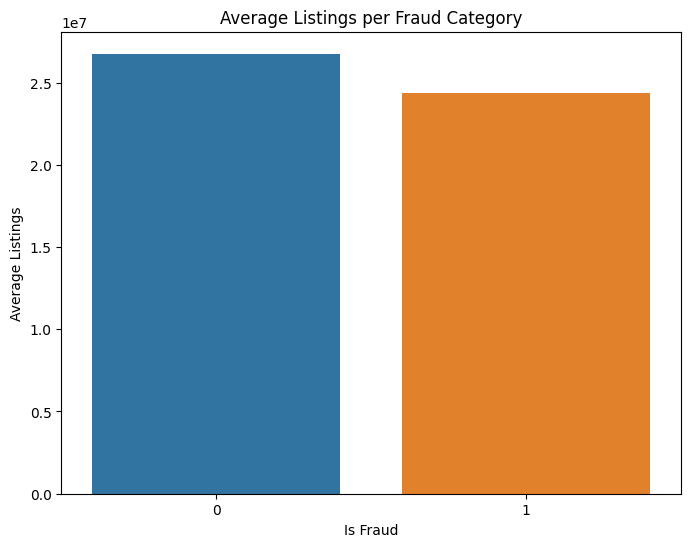

In [8]:
plt.figure(figsize=(8,6))

# Calculate mean listings for each fraud category
avg_listings_per_fraud_category = data.groupby('is_fraud')['listing_id'].mean().reset_index()

sns.barplot(x='is_fraud', y='listing_id', data=avg_listings_per_fraud_category)
plt.title('Average Listings per Fraud Category')
plt.xlabel('Is Fraud')
plt.ylabel('Average Listings')
plt.show()

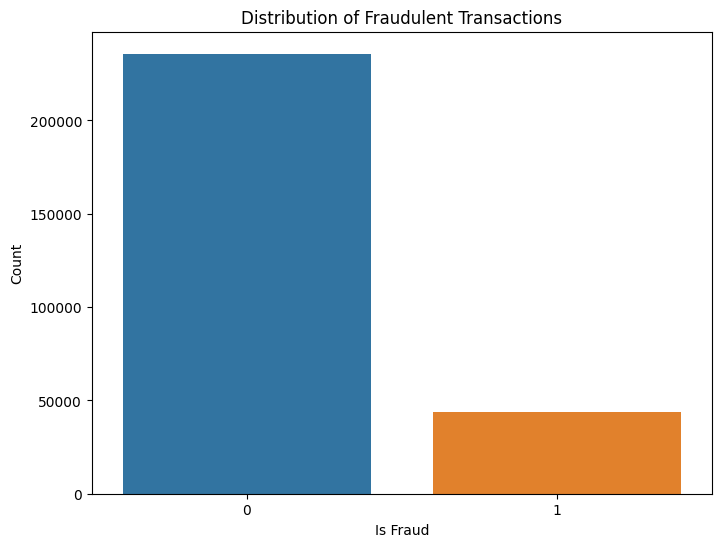

In [9]:
# Plotting the distribution of fraud vs. not fraud
plt.figure(figsize=(8,6))
sns.countplot(x='is_fraud', data=data)
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

In [10]:
# Convert categorical variables to numerical using get_dummies
data = pd.get_dummies(data, drop_first=True)

# Split dataset into features (X) and target (y)
X = data.drop('is_fraud', axis=1)
y = data['is_fraud']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

# Create a RandomForest Classifier
clf = RandomForestClassifier()

# Train the model using the training sets
clf.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred = clf.predict(X_test)

In [11]:
# Model Accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# Classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9441928641227924
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     70849
           1       0.82      0.82      0.82     13065

    accuracy                           0.94     83914
   macro avg       0.89      0.89      0.89     83914
weighted avg       0.94      0.94      0.94     83914

[[68548  2301]
 [ 2382 10683]]


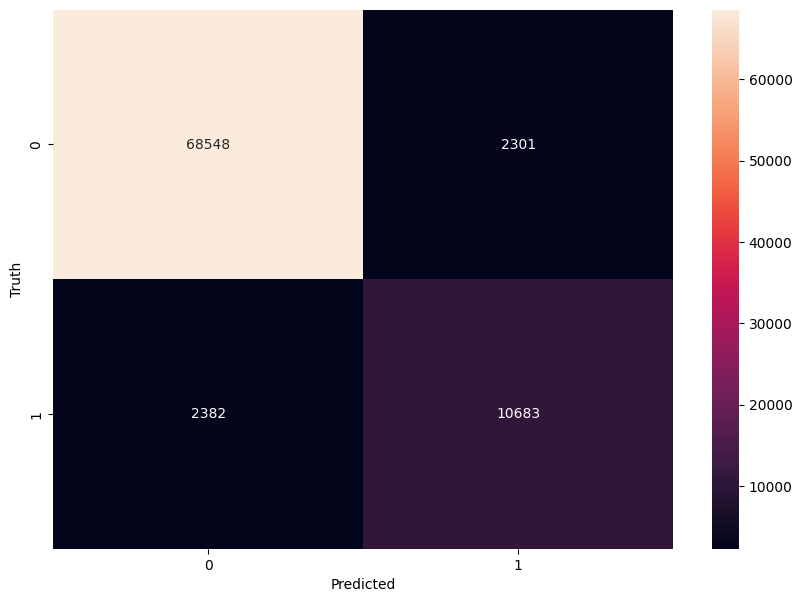

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cnf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

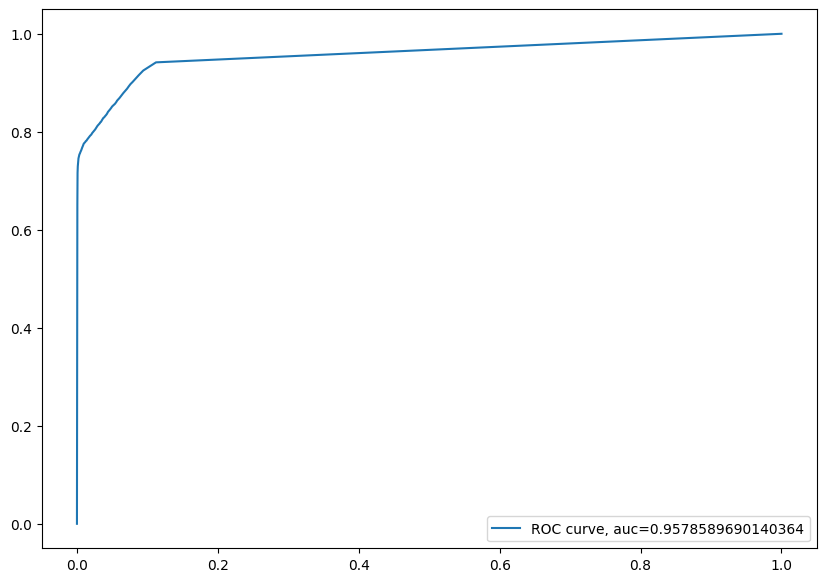

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute predicted probabilities
y_pred_proba = clf.predict_proba(X_test)[::,1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Compute ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="ROC curve, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()